In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from os import path
from linear_opt.lin_metabolism import LinearMetabolicModel
from linear_opt.lin_metabolism import GrowthRateOptParams
from linear_opt.lin_metabolism import SimpleFirstOrderRateLaw

from SALib import ProblemSpec

In [2]:
model_dir = '../models/linear/respiration/'
m_fname = path.join(model_dir, 'glucose_resp_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_resp_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
lam.print_model()

Metabolites:
         NC  NOSC  internal                                               note
C_red     1   0.0         0         reduced C, 1 C of extracellular "glucose" 
C_ox      1   4.0         0                                  oxidized C, "CO2"
E_red     1  -4.0         0  reduced donor/acceptor, 2 H2O, NC = 1 for bala...
E_ox      1   0.0         0  oxidized e- donor/acceptor, O2, has fictional ...
ECH      20  -0.1         1  Reduced 2e- carrier, 20*-0.1 => 2 more e- than...
EC       20   0.0         1  Oxidized single e- carrier with 20 carbons. No...
ATP      10   0.0         1                      ATP -- has 10 C atoms really.
ADP      10   0.0         1                                                ADP
biomass   1   0.0         0                   Everything per C, default ZC = 0
Stoichiometries:
                 C_red  C_ox  E_red  E_ox  ECH   EC  ATP  ADP  biomass  \
process                                                                  
oxidation         -1.0   1.0   0

In [3]:
params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                             rate_law=SimpleFirstOrderRateLaw(),
                             fixed_ATP=0.01, fixed_NADH=0.01,
                             fixed_re=10, fixed_ra=0.3)
p = lam.max_growth_rate_problem(params)
p.solve(verbose=True)

lam.solution_as_dict(p)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 15 08:58:58 PM: Your problem has 5 variables, 3 constraints, and 23 parameters.
(CVXPY) Aug 15 08:58:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 15 08:58:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 15 08:58:58 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 15 08:58:58 PM: Reduction chain: EvalParams -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Aug 15 08:58:58 PM: Applying reduction EvalParams
(CVXPY) Aug 15 08:58:58 PM: Applying 

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


defaultdict(float,
            {'lambda_hr': 1.101550036051983e-09,
             'maint': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             'oxidation_gamma': 5e-05,
             'oxidation_phi': 0.00825158918851623,
             'oxidation_flux': 4.1257945942581156e-07,
             'reduction_gamma': 0.0002,
             'reduction_phi': 0.08251589190862073,
             'reduction_flux': 1.6503178381724147e-05,
             'anabolism_gamma': 5e-05,
             'anabolism_phi': 7.649653028138771e-09,
             'anabolism_flux': 3.8248265140693857e-13,
             'ATP_homeostasis_gamma': 5e-05,
             'ATP_homeostasis_phi': 0.3713215112810497,
             'ATP_homeostasis_flux': 1.8566075564052484e-05})

In [4]:
# Do a quick run of the model to make sure it is feasible
params = GrowthRateOptParams(maintenance_cost=1e-3, phi_O=0.1)
opt, problem = lam.maximize_growth_rate(params)
opt

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


11.435281659402914

In [5]:
concs = np.logspace(-4, 0, 50)
ATPgrid, NADHgrid = np.meshgrid(concs, concs)
lambda_grid = np.zeros_like(ATPgrid)

for i, ATP in enumerate(concs):
    for j, NADH in enumerate(concs):
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=ATP, fixed_NADH=NADH)
        opt, _ = lam.maximize_growth_rate(params)
        lambda_grid[i, j] = opt

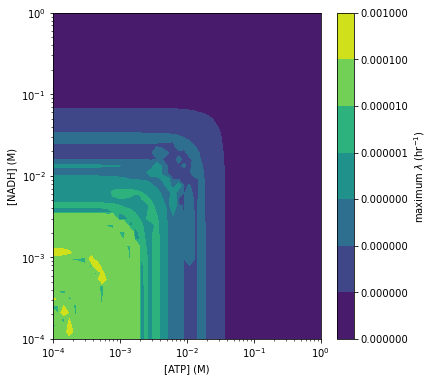

In [6]:
plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, 3, cmap='viridis', norm=LogNorm())
plt.xlabel('[ATP] (M)')
plt.ylabel('[NADH] (M)')
cb = plt.colorbar(label=r'maximum $\lambda$ (hr$^{-1}$)')
plt.show()

In [7]:
# Same as above, first order kinetics
concs = np.logspace(-4, 0, 50)
ATPgrid, NADHgrid = np.meshgrid(concs, concs)
lambda_grid = np.zeros_like(ATPgrid)

for i, ATP in enumerate(concs):
    for j, NADH in enumerate(concs):
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=ATP, fixed_NADH=NADH,
                                     fixed_re=10, fixed_ra=0.1,
                                     rate_law=SimpleFirstOrderRateLaw())
        opt, _ = lam.maximize_growth_rate(params)
        lambda_grid[i, j] = opt

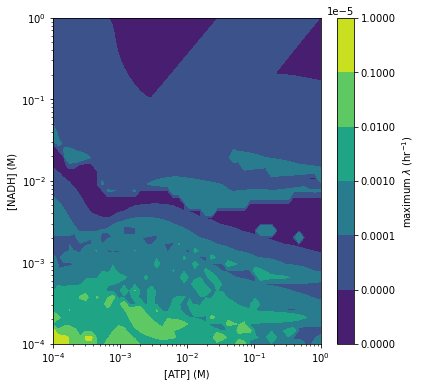

In [8]:
plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, 3, cmap='viridis', norm=LogNorm())
plt.xlabel('[ATP] (M)')
plt.ylabel('[NADH] (M)')
cb = plt.colorbar(label=r'maximum $\lambda$ (hr$^{-1}$)')
plt.show()

In [20]:
p = lam.max_anabolic_rate_problem(phi_o=0.4, max_lambda_hr=0.1)
lambdas = np.arange(0.1, 1.501, 0.01)
results = []

for lam_val in lambdas:
    p.param_dict['max_lambda_hr'].value = lam_val
    res = p.solve()
    d = lam.solution_as_dict(p)
    d.update(lam.model_as_dict())
    results.append(d)

phi_df = pd.DataFrame(results)
phi_df['max_lambda_hr'] = lambdas
phi_df.head()

,lambda_hr,maint,max_lambda_hr,phi_o,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,...,ATP_homeostasis_gamma,ZCB,ZCorg,ZCprod,S1,S2,S3,S4,S5,S6
0,0.10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.10,0.4,0.086325,0.000043,0.086325,0.000173,0.055556,0.000028,...,0.0005,0.0,0.0,4.0,2.0,0.5,0.5,1.0,0.3,0.0
1,0.11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.11,0.4,0.085726,0.000043,0.085726,0.000171,0.061111,0.000031,...,0.0005,0.0,0.0,4.0,2.0,0.5,0.5,1.0,0.3,0.0
2,0.12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.12,0.4,0.085128,0.000043,0.085128,0.000170,0.066667,0.000033,...,0.0005,0.0,0.0,4.0,2.0,0.5,0.5,1.0,0.3,0.0
3,0.13,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.13,0.4,0.084530,0.000042,0.084530,0.000169,0.072222,0.000036,...,0.0005,0.0,0.0,4.0,2.0,0.5,0.5,1.0,0.3,0.0
4,0.14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.14,0.4,0.083932,0.000042,0.083932,0.000168,0.077778,0.000039,...,0.0005,0.0,0.0,4.0,2.0,0.5,0.5,1.0,0.3,0.0


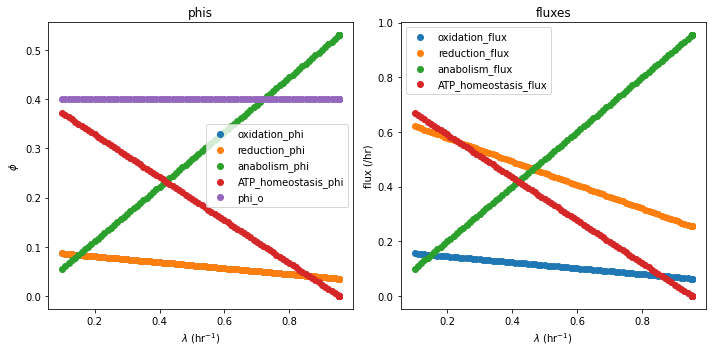

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plt.sca(axs[0])

x = phi_df['lambda_hr']
phi_cols = [c for c in phi_df.columns if c.endswith('phi')] + ['phi_o']
for col in phi_cols:
    plt.scatter(x, phi_df[col], label=col)
plt.title('phis')
plt.xlabel(r'$\lambda$ (hr$^{-1}$)')
plt.ylabel(r'$\phi$')   
plt.legend()

plt.sca(axs[1])
j_cols = [c for c in phi_df.columns if c.endswith('flux')]
for col in j_cols:
    plt.scatter(x, phi_df[col]*3600, label=col)
plt.title('fluxes')
plt.xlabel(r'$\lambda$ (hr$^{-1}$)')
plt.ylabel(r'flux (/hr)')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
# Use the SAlib tools to generate parameters for a sensitivity analysis
ps = ProblemSpec({
        "names": ["phi_o", "S6", "m_resp", "resp_ATP_per_e", "m_ATP_homeostasis"],
        "groups": None,
        "bounds": [[0.3, 0.5], [-0.5, 0.5], [10, 10000], [0.2, 2], [10, 10000],],
        "outputs": ["lambda_max"],
    })
ps.sample_sobol(64)

results = []

for phi_o, s6, m_resp, atp_per_e, m_homeo in ps.samples:
    lam.set_S6(s6)
    lam.set_process_mass('reduction', m_resp)
    #lam.set_process_mass('ATP_homeostasis', m_homeo)
    lam.set_ATP_yield('reduction', atp_per_e)
    max_lam, opt_prob = lam.maximize_lambda(phi_o=phi_o)

    d = lam.solution_as_dict(opt_prob)
    d.update(lam.model_as_dict())
    d['resp_ATP_per_e'] = atp_per_e
    results.append(d)

res_df = pd.DataFrame(results)
res_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,lambda_hr,maint,phi_o,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,ATP_homeostasis_phi,...,ZCB,ZCorg,ZCprod,S1,S2,S3,S4,S5,S6,resp_ATP_per_e
0,0.675352,0,0.479240,0.129233,0.000065,0.016332,0.000074,0.375196,0.000188,3.705832e-10,...,-0.985017,0.0,4.0,2.0,0.5,0.5,0.325351,0.3,0.492508,0.325351
1,0.691278,0,0.466959,0.132280,0.000066,0.016717,0.000075,0.384044,0.000192,3.791861e-10,...,-0.985017,0.0,4.0,2.0,0.5,0.5,0.325351,0.3,0.492508,0.325351
2,0.815020,0,0.479240,0.026152,0.000013,0.041819,0.000189,0.452789,0.000226,6.321366e-12,...,0.602284,0.0,4.0,2.0,0.5,0.5,0.325351,0.3,-0.301142,0.325351
3,0.257994,0,0.479240,0.049369,0.000025,0.328061,0.000028,0.143330,0.000072,0.000000e+00,...,-0.985017,0.0,4.0,2.0,0.5,0.5,0.325351,0.3,0.492508,0.325351
4,0.702009,0,0.479240,0.120092,0.000060,0.010663,0.000048,0.390005,0.000195,5.490332e-10,...,-0.985017,0.0,4.0,2.0,0.5,0.5,0.592006,0.3,0.492508,0.592006


In [7]:
ps.set_results(res_df.lambda_hr.values)
ps.analyze_sobol(print_to_console=True, calc_second_order=True)

                         ST   ST_conf
phi_o              0.020642  0.013687
S6                 0.231901  0.124714
m_resp             0.615705  0.188436
resp_ATP_per_e     0.110881  0.064239
m_ATP_homeostasis  0.000000  0.000000
                         S1   S1_conf
phi_o              0.015809  0.051844
S6                 0.096279  0.190397
m_resp             0.658525  0.238167
resp_ATP_per_e     0.065984  0.085612
m_ATP_homeostasis  0.000000  0.000000
                                           S2   S2_conf
(phi_o, S6)                          0.039940  0.071811
(phi_o, m_resp)                     -0.014402  0.141343
(phi_o, resp_ATP_per_e)              0.024852  0.076180
(phi_o, m_ATP_homeostasis)           0.019010  0.070770
(S6, m_resp)                        -0.041032  0.258898
(S6, resp_ATP_per_e)                 0.046404  0.201683
(S6, m_ATP_homeostasis)              0.041605  0.199484
(m_resp, resp_ATP_per_e)             0.006204  0.504464
(m_resp, m_ATP_homeostasis)         -0.0

{'names': ['phi_o', 'S6', 'm_resp', 'resp_ATP_per_e', 'm_ATP_homeostasis'],
 'groups': None,
 'bounds': [[0.3, 0.5], [-0.5, 0.5], [10, 10000], [0.2, 2], [10, 10000]],
 'outputs': ['lambda_max'],
 'num_vars': 5,
 'sample_scaled': True}

<AxesSubplot: xlabel='reduction_m_kDa', ylabel='lambda_hr'>

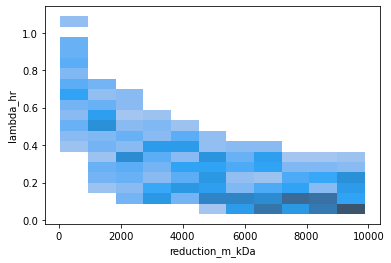

In [8]:
sns.histplot(data=res_df, y='lambda_hr', x='reduction_m_kDa', legend=False)

In [9]:
ZCBs = np.arange(-3, 3.01, 0.05)
phi_os = np.arange(0.1, 0.501, 0.2)
homeo_costs = np.logspace(1, 5, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)
results = []
for z in ZCBs:
    for phi_o in phi_os:
        for homeo_cost in homeo_costs:
            for resp_cost in resp_costs:
                for atp_per_e in ATP_per_es:
                    try:
                        ref_lam = lmm.copy()
                        ref_lam.set_ZCB(z)
                        ref_lam.set_process_mass('reduction', resp_cost)
                        ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                        ref_lam.set_ATP_yield('reduction', atp_per_e)
                        m, opt_p = ref_lam.maximize_lambda(min_phi_o=phi_o)

                        d = ref_lam.model_as_dict()
                        d.update(ref_lam.solution_as_dict(opt_p))
                        d['reduction_ATP_per_e'] = atp_per_e
                        results.append(d)
                    except Exception as e:
                        print(e)
                        continue
res_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [10]:
res_df['reduction_gamma,oxidation_gamma,anabolism_gamma'.split(',')].head()

,reduction_gamma,oxidation_gamma,anabolism_gamma
0,0.020,0.0005,0.0005
1,0.020,0.0005,0.0005
2,0.020,0.0005,0.0005
3,0.020,0.0005,0.0005
4,0.002,0.0005,0.0005


In [18]:
def analytic_gamma(row):
    """Calculates gamma from an analytic solution by Lagrange multipliers."""
    g_ana = row.anabolism_gamma
    g_red = row.reduction_gamma
    g_ox = row.oxidation_gamma
    g_h = row.ATP_homeostasis_gamma
    phi_h = row.ATP_homeostasis_phi
    phi_o = row.phi_o
    m = row.maint
    S1, S2, S3, S4, S5, S6 = row.S1, row.S2, row.S3, row.S4, row.S5, row.S6
    phi_term = (-1 + phi_h + phi_o)
    Sterm = S1*S5 - S3*S6
    num = -g_ana*(S2*g_red*(m + g_h*phi_h + S3*g_ox*phi_term))
    num += -g_ana*(S1*g_ox*(m + g_h*phi_h + S4*g_red*phi_term))
    denom = Sterm*g_ana*g_ox
    denom += (S4*(S6*g_ana + S1*g_ox) + S2*(S5*g_ana + S3*g_ox))*g_red
    return 3600*num/denom

analytic_gammas = res_df.apply(analytic_gamma, axis=1)

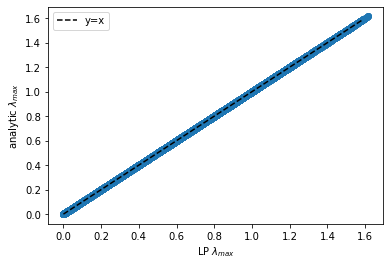

In [21]:
plt.scatter(res_df.lambda_hr.values, analytic_gammas)
xs = np.arange(0, 1.6, 0.01)
plt.plot(xs,xs, ls='--', color='k', label='y=x')
plt.legend()
plt.xlabel('LP $\lambda_{max}$')
plt.ylabel('analytic $\lambda_{max}$')
plt.show()

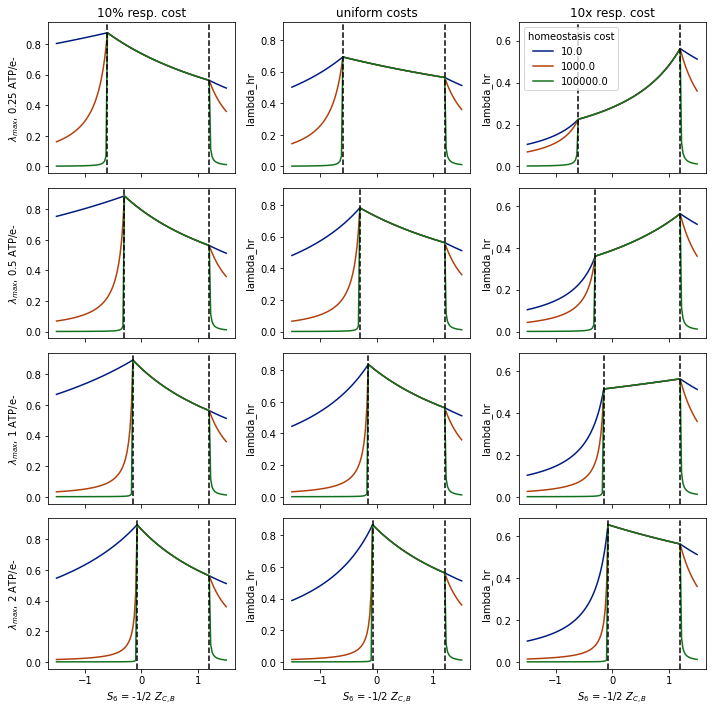

In [13]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey='col')

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.reduction_m_kDa == resp_cost, res_df.min_phi_o == phi_os[2])
        mask = np.logical_and(mask, res_df.reduction_ATP_per_e == a_per_e)
        sns.lineplot(data=res_df[mask], x='S6', y='lambda_hr', hue='ATP_homeostasis_m_kDa', palette='dark')
        
        masked = res_df[mask]
        S1 = masked.S1.values[0]
        S2 = masked.S2.values[0]
        S3 = masked.S3.values[0]
        S4 = masked.S4.values[0]
        S5 = masked.S5.values[0]        
        S6_lb = -S2*S5/S4
        S6_ub = S1*S5/S3
        plt.axvline(S6_lb, color='k', linestyle='--')
        plt.axvline(S6_ub, color='k', linestyle='--')
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\lambda_{{max}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend(title='homeostasis cost').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()

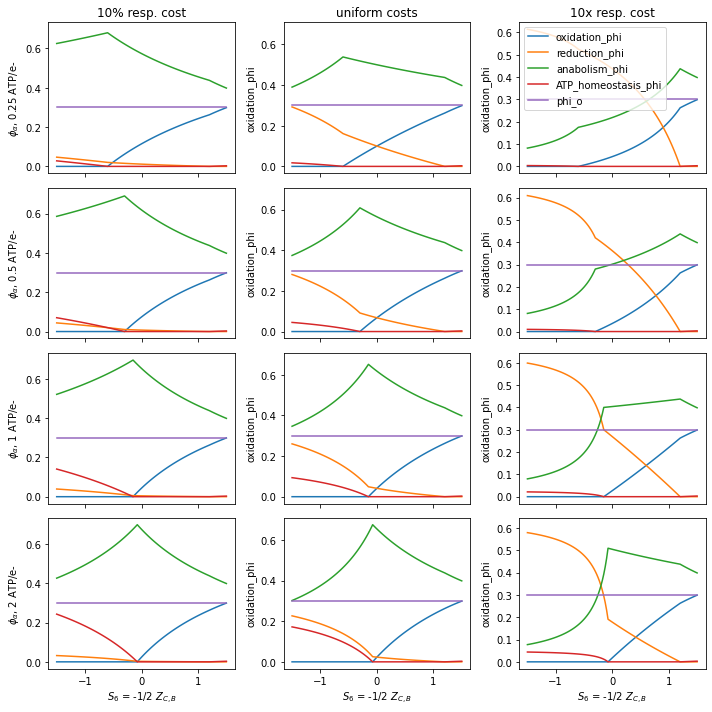

In [14]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey='col')
phi_cols = [c for c in res_df.columns if c.endswith('phi')] + ['phi_o']

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.reduction_m_kDa == resp_cost, res_df.min_phi_o == phi_os[1])
        mask = np.logical_and(mask, res_df.reduction_ATP_per_e == a_per_e)
        mask = np.logical_and(mask, res_df.ATP_homeostasis_m_kDa == 10)

        for c in phi_cols:
            sns.lineplot(data=res_df[mask], x='S6', y=c, palette='dark', label=c)
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\phi_{{\alpha}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend().set_visible(True)

plt.tight_layout()
#plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()

In [15]:
max_lambdas = np.linspace(0.01, 3, 50)
homeo_costs = np.logspace(1, 3, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)
res_dict = dict(ZCB=[], phi_o=[], homeo_cost=[], lambda_max=[], S6=[], resp_cost=[], resp_ATP_per_e=[])

results = []

for max_lambda in max_lambdas:
    for homeo_cost in homeo_costs:
        for resp_cost in resp_costs:
            for atp_per_e in ATP_per_es:
                try:
                    ref_lam = lmm.copy()
                    ref_lam.set_process_mass('reduction', resp_cost)
                    ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                    ref_lam.set_ATP_yield('reduction', atp_per_e)
                    m, opt_p = ref_lam.maximize_lambda(min_phi_o=0.4, max_lambda_hr=max_lambda)

                    d = ref_lam.model_as_dict()
                    d.update(ref_lam.solution_as_dict(opt_p))
                    d['reduction_ATP_per_e'] = atp_per_e
                    results.append(d)
                except:
                    continue
res_df2 = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_44683/1916662547.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(res_df[mask].lambda_hr.max(), color='k', linestyle='--', label='$\lambda_{max}$')


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

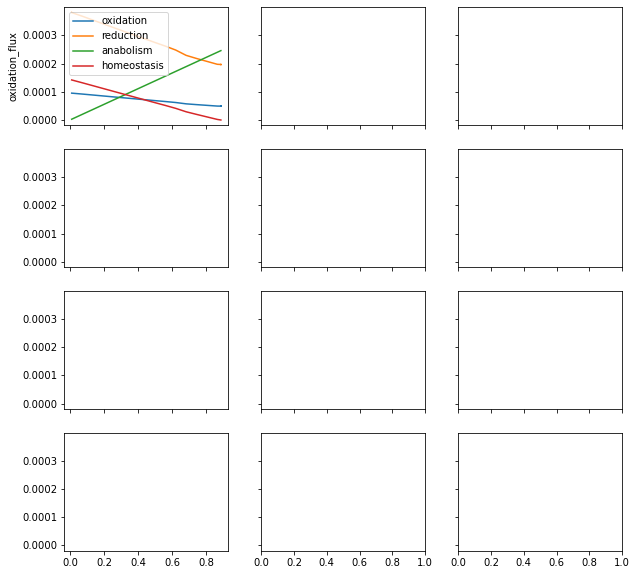

In [16]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex='col', sharey=True)

titles = '10% reduction cost,uniform costs,10x reduction cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df2.reduction_m_kDa == resp_cost, res_df2.reduction_ATP_per_e == a_per_e)
        mask = np.logical_and(mask, res_df2.ATP_homeostasis_m_kDa == 100)
        sns.lineplot(data=res_df2[mask], x='lambda_hr', y='oxidation_flux', palette='dark', label='oxidation')
        sns.lineplot(data=res_df2[mask], x='lambda_hr', y='reduction_flux', palette='dark', label='reduction')
        sns.lineplot(data=res_df2[mask], x='lambda_hr', y='anabolism_flux', palette='dark', label='anabolism')
        sns.lineplot(data=res_df2[mask], x='lambda_hr', y='ATP_homeostasis_flux', palette='dark', label='homeostasis')
        plt.axvline(res_df[mask].lambda_hr.max(), color='k', linestyle='--', label='$\lambda_{max}$')        
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'flux, {0} ATP/e-'.format(a_per_e))
        if i == 3:
            plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')

plt.sca(axs[0,2])
plt.legend(title='flux (rate/cell mass)').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_v_flux_sweep.png', dpi=300, facecolor='white')
plt.show()

<AxesSubplot: xlabel='reduction_m_kDa', ylabel='lambda_hr'>

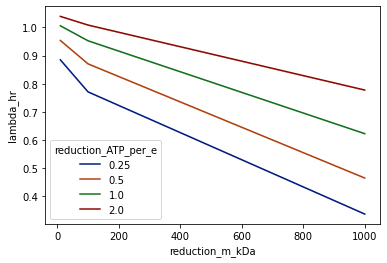

In [ ]:
max_idx = res_df2.groupby('reduction_m_kDa,ATP_homeostasis_m_kDa,reduction_ATP_per_e'.split(',')).lambda_hr.idxmax()
max_lambda = res_df2.loc[max_idx]

sns.lineplot(data=max_lambda, x='reduction_m_kDa', y='lambda_hr', hue='reduction_ATP_per_e', palette='dark')